## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import urllib.request, urllib.parse, urllib.error
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
API_key = '294f4c0e6d0861470f47e84017c8e2c1'

In [3]:
#The first API request is to obtain a list of movies for a given year with the filter of vote_count.

def API_search(year,vote_count):
    #This request pulls the first page of the search request
    resp = requests.get('https://api.themoviedb.org/3/discover/movie?api_key=' + str(API_key) +'&language=en-US&vote_count.gte='+str(vote_count)+'&primary_release_year='+ str(year))
    data_p1 = dict(resp.json())

    #We can also use this request to see how many pages there are in the search, 
    #we will need to add all the pages of the search to the dataframe
    search_pages = data_p1['total_pages']
    data = pd.DataFrame.from_dict(data_p1['results'])
    url = 'https://api.themoviedb.org/3/discover/movie?api_key=' + str(API_key) +'&language=en-US&vote_count.gte='+str(vote_count)+'&primary_release_year='+ str(year)+'&page='
    for page in range(2,search_pages+1):
        resp = requests.get(url + str(page))
        temp = dict(resp.json())
        df_by_page = pd.DataFrame.from_dict(temp['results'])
        data = pd.concat([data,df_by_page], ignore_index=True)

    data = data.set_index('id')
    # Create a list of all the movies from the search above. Which is in decending popularity order.
    return data.index.values.tolist()


In [4]:
movies_index = []

vote_count = 1000
search_years = list(range(2010,2020))

for year in search_years:
    movies_index = movies_index + API_search(year,vote_count)
    
len(movies_index)

1193

In [5]:
#Here is an example of the API request data.  
#If we want to change our dataframes, to target more data, it would be easy to add in the function in an upcoming step
resp = requests.get('https://api.themoviedb.org/3/movie/' + str(movies_index[0]) + '?api_key=' + str(API_key))
dict(resp.json())

{'adult': False,
 'backdrop_path': '/s3TBrRGB1iav7gFOCNx3H31MoES.jpg',
 'belongs_to_collection': None,
 'budget': 160000000,
 'genres': [{'id': 28, 'name': 'Action'},
  {'id': 878, 'name': 'Science Fiction'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'http://inceptionmovie.warnerbros.com/',
 'id': 27205,
 'imdb_id': 'tt1375666',
 'original_language': 'en',
 'original_title': 'Inception',
 'overview': 'Cobb, a skilled thief who commits corporate espionage by infiltrating the subconscious of his targets is offered a chance to regain his old life as payment for a task considered to be impossible: "inception", the implantation of another person\'s idea into a target\'s subconscious.',
 'popularity': 85.972,
 'poster_path': '/9gk7adHYeDvHkCSEqAvQNLV5Uge.jpg',
 'production_companies': [{'id': 923,
   'logo_path': '/5UQsZrfbfG2dYJbx8DxfoTr2Bvu.png',
   'name': 'Legendary Entertainment',
   'origin_country': 'US'},
  {'id': 9996,
   'logo_path': '/3tvBqYsBhxWeHlu62SIJ1el93O7.png',
   'n

In [6]:
#Defines a function to then arrange the data into a dictionary for a given movie.  

def API_request(movie):
    resp = requests.get('https://api.themoviedb.org/3/movie/' + str(movie) + '?api_key=' + str(API_key))
    if resp.status_code == requests.codes.ok:
        temp = dict(resp.json())
        movie = {}
        movie['imdb_id'] = temp['imdb_id']
        movie['popularity'] = temp['popularity']
        movie['release_date'] = pd.to_datetime(temp['release_date'])
        movie['genres'] = [genre['name'] for genre in temp['genres']]
        movie['title'] = temp['title']
        movie['budget'] = int(temp['budget'])
        movie['revenue'] = int(temp['revenue'])
        movie['runtime_mins'] = temp['runtime']
        movie['vote_average'] = temp['vote_average']        
        movie['vote_count'] = temp['vote_count']   
        movie['genre_count'] = len(temp['genres'])
        return movie

In [7]:
#See an example of what the API_request provides per movie
print(API_request(movies_index[0]))

{'imdb_id': 'tt1375666', 'popularity': 85.972, 'release_date': Timestamp('2010-07-15 00:00:00'), 'genres': ['Action', 'Science Fiction', 'Adventure'], 'title': 'Inception', 'budget': 160000000, 'revenue': 825532764, 'runtime_mins': 148, 'vote_average': 8.3, 'vote_count': 26520, 'genre_count': 3}


In [8]:
## Execution time varies on how large our subset is ##

#Make requests to the API for the movie data
imbd_API_data = list(map(lambda x: API_request(x),movies_index))

In [9]:
#Create a dataframe of the data obtained
df = pd.DataFrame.from_dict(imbd_API_data)
# df = df.drop(['release_date'], axis=1)

#Remove any data where the budget or the revenue have 0's
df = df[(df['budget'] > 0) & (df['revenue'] > 0)]

#Create a new column which performs a calculation of the "Return on Investment"
#Filter the dataframe to only include data which has a "ROI" greater than 1.75,
#which are considered to be profitable movies
df['ROI'] = (df['revenue'] - df['budget']) / df['budget']
# df = df[df['ROI'] > 1.75]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1049 entries, 0 to 1188
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   imdb_id       1049 non-null   object        
 1   popularity    1049 non-null   float64       
 2   release_date  1049 non-null   datetime64[ns]
 3   genres        1049 non-null   object        
 4   title         1049 non-null   object        
 5   budget        1049 non-null   int64         
 6   revenue       1049 non-null   int64         
 7   runtime_mins  1049 non-null   int64         
 8   vote_average  1049 non-null   float64       
 9   vote_count    1049 non-null   int64         
 10  genre_count   1049 non-null   int64         
 11  ROI           1049 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(3)
memory usage: 106.5+ KB


In [10]:
#Define a function to remove outliers based on columns to target

def iqr_data_filter(df, columns, ticker_width):

    q1 = df.quantile(0.25)                 
    q3 = df.quantile(0.75)
    iqr = q3 - q1
    
    for column in columns:
        filter_lower = df[column] >= q1[column] - ticker_width * iqr[column]
        filter_upper = df[column] <= q3[column] + ticker_width * iqr[column]
        df = df[(filter_lower) & (filter_upper)]
      
    return df

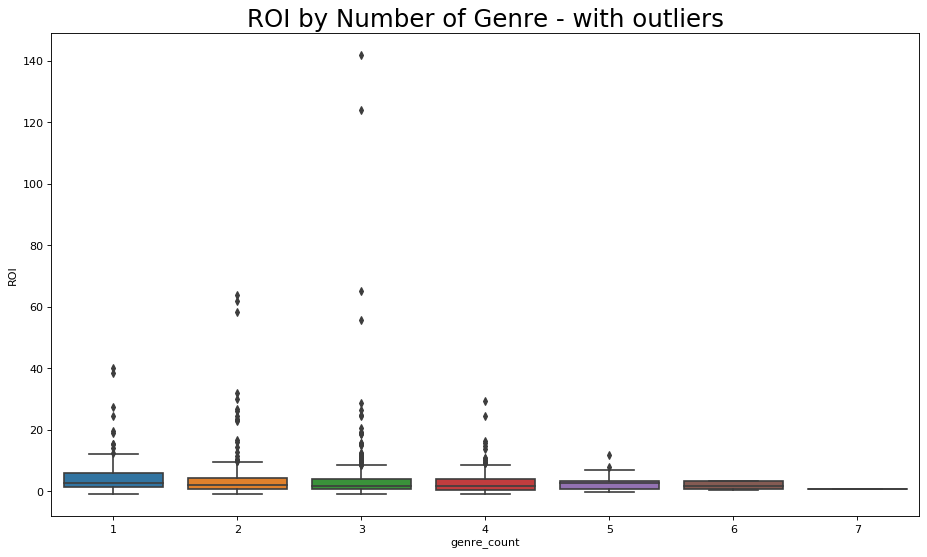

In [11]:
# Draw Plot
plt.figure(figsize=(14,8), dpi= 80)
sns.boxplot(x='genre_count', y='ROI', data=df, notch=False)
plt.title('ROI by Number of Genre - with outliers', fontsize=22)
# plt.ylim(-2, 16)
plt.show()

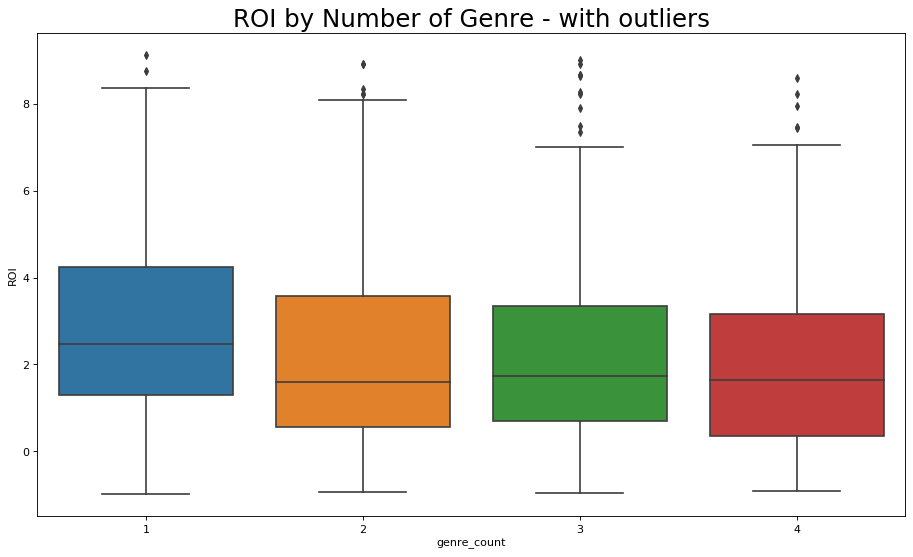

In [12]:
# col_to_filter = ['ROI', 'genre_count']
col_to_filter = ['ROI','genre_count']
df_filtered = iqr_data_filter(df, col_to_filter, 1.5)

# Draw Plot
plt.figure(figsize=(14,8), dpi= 80)
sns.boxplot(x='genre_count', y='ROI', data=df_filtered, notch=False)
plt.title('ROI by Number of Genre - with outliers', fontsize=22)
# plt.ylim(-2, 16)
plt.show()

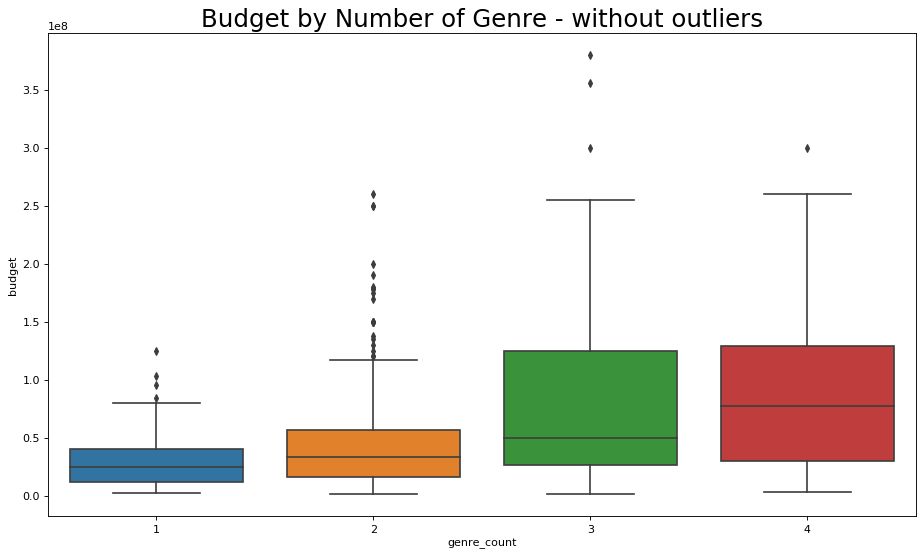

In [13]:
# Draw Plot
plt.figure(figsize=(14,8), dpi= 80)
sns.boxplot(x='genre_count', y='budget', data=df_filtered, notch=False)
plt.title('Budget by Number of Genre - without outliers', fontsize=22)
plt.show()

In [14]:
#Split the genres column into individual rows and set the index to "imbd_id"
s = df_filtered.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
df_expanded = df_filtered.drop('genres',axis=1).join(s).set_index('imdb_id')

df_expanded.head()

,popularity,release_date,title,budget,revenue,runtime_mins,vote_average,vote_count,genre_count,ROI,genre
imdb_id,,,,,,,,,,,
tt1375666,85.972,2010-07-15,Inception,160000000,825532764,148,8.3,26520,3,4.159580,Action
tt1375666,85.972,2010-07-15,Inception,160000000,825532764,148,8.3,26520,3,4.159580,Science Fiction
tt1375666,85.972,2010-07-15,Inception,160000000,825532764,148,8.3,26520,3,4.159580,Adventure
tt0926084,44.554,2010-10-17,Harry Potter and the Deathly Hallows: Part 1,250000000,954305868,146,7.8,13068,2,2.817223,Adventure
tt0926084,44.554,2010-10-17,Harry Potter and the Deathly Hallows: Part 1,250000000,954305868,146,7.8,13068,2,2.817223,Fantasy


In [15]:
df_expanded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2429 entries, tt1375666 to tt8663516
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   popularity    2429 non-null   float64       
 1   release_date  2429 non-null   datetime64[ns]
 2   title         2429 non-null   object        
 3   budget        2429 non-null   int64         
 4   revenue       2429 non-null   int64         
 5   runtime_mins  2429 non-null   int64         
 6   vote_average  2429 non-null   float64       
 7   vote_count    2429 non-null   int64         
 8   genre_count   2429 non-null   int64         
 9   ROI           2429 non-null   float64       
 10  genre         2429 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(5), object(2)
memory usage: 227.7+ KB


In [23]:
df_expanded['year'] = df_expanded['release_date'].dt.year
df_expanded['month'] = df_expanded['release_date'].dt.month

In [24]:
df_expanded.sort_values( by ='ROI', ascending = False).head()

,popularity,release_date,title,budget,revenue,runtime_mins,vote_average,vote_count,genre_count,ROI,genre,year,month
imdb_id,,,,,,,,,,,,,
tt3063516,11.120,2013-10-22,Jackass Presents: Bad Grandpa,15000000,151831537,92,6.0,1099,1,9.122102,Comedy,2013,10
tt5580390,27.041,2017-12-01,The Shape of Water,19500000,194989655,123,7.2,8885,3,8.999469,Romance,2017,12
tt5580390,27.041,2017-12-01,The Shape of Water,19500000,194989655,123,7.2,8885,3,8.999469,Fantasy,2017,12
tt5580390,27.041,2017-12-01,The Shape of Water,19500000,194989655,123,7.2,8885,3,8.999469,Drama,2017,12
tt5700672,29.295,2016-07-20,Train to Busan,8820000,87547518,118,7.7,3766,3,8.926022,Action,2016,7


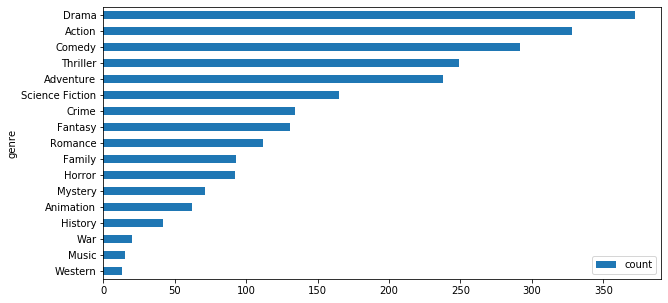

In [25]:
#What are the most common genres?
common_genres = {}
common_genres['count'] = df_expanded.groupby(['genre']).count()['vote_count']
common_genres = pd.DataFrame.from_dict(common_genres).sort_values( by ='count', ascending = True)
common_genres.plot.barh(figsize=(10,5))

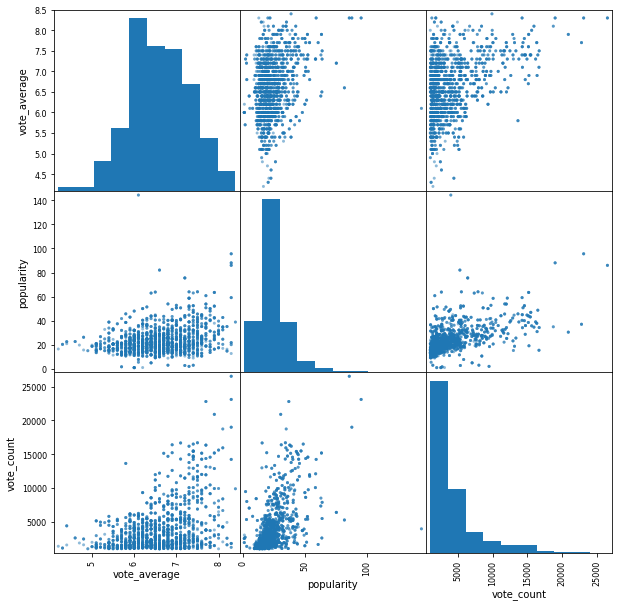

In [21]:
df_expanded.head()
pd.plotting.scatter_matrix(df_expanded[['vote_average','popularity','vote_count']], figsize=(10,10));

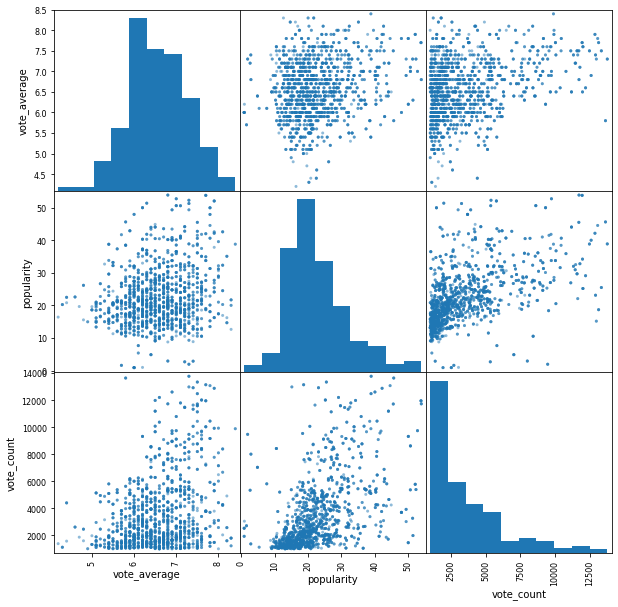

In [22]:
# col_to_filter = ['vote_average', 'popularity', 'vote_count']
col_to_filter = ['vote_average', 'popularity', 'vote_count']
df_expanded_filtered = iqr_data_filter(df_expanded, col_to_filter, 2.5)

pd.plotting.scatter_matrix(df_expanded_filtered[['vote_average','popularity','vote_count']], figsize=(10,10));